In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import mplfinance as mpf
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import warnings
warnings.filterwarnings("ignore")

<h3> Load Dataset </h3>

The Federal Reserve Economic Database (FRED) provides historical daily US Treasury yield data.

In [2]:
df = pd.read_csv('datasets/fred_us_treasury_yields.csv')
mask = (df['Date'] >= '2000-01-03') & (df['Date'] <= '2013-05-31')
df = df.loc[mask]
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
tyields = df[["DGS3MO","DGS1","DGS5","DGS10","DAAA","DBAA"]]

In [3]:
tyields.head()

,DGS3MO,DGS1,DGS5,DGS10,DAAA,DBAA
Date,,,,,,
2000-01-03,5.48,6.09,6.50,6.58,7.75,8.27
2000-01-04,5.43,6.00,6.40,6.49,7.69,8.21
2000-01-05,5.44,6.05,6.51,6.62,7.78,8.29
2000-01-06,5.41,6.03,6.46,6.57,7.72,8.24
2000-01-07,5.38,6.00,6.42,6.52,7.69,8.22


In [4]:
tyields.tail()

,DGS3MO,DGS1,DGS5,DGS10,DAAA,DBAA
Date,,,,,,
2013-05-27,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-28,0.05,0.13,1.02,2.15,4.06,4.88
2013-05-29,0.05,0.14,1.02,2.13,4.04,4.88
2013-05-30,0.04,0.13,1.01,2.13,4.06,4.90
2013-05-31,0.04,0.14,1.05,2.16,4.09,4.95


Our focus is on **DGS10**, the yield of constant-maturity 10 Year US bond.

<h3> Handle DGS10 Missing Data </h3>

In [5]:
# Print the sum of missing values in each column of 'tyields'
print(tyields.isna().sum())

# Identify rows for which 'DGS10' data is missing
tyields_not_avail = tyields[tyields['DGS10'].isna()].index
print("\nIdentify rows for which DGS10 data is missing: ")
print(tyields.index.to_series().loc[tyields_not_avail])

# Set 'tyields' as a sub DataFrame with non-missing data for 'DGS10'
tyields = tyields.dropna(subset=['DGS10'])

# Print the sum of missing values in each column of 'tyields'
print("\n")
print(tyields.isna().sum())

DGS3MO    144
DGS1      144
DGS5      144
DGS10     144
DAAA      144
DBAA      144
dtype: int64

Identify rows for which DGS10 data is missing: 
Date
2000-01-17   2000-01-17
2000-02-21   2000-02-21
2000-04-21   2000-04-21
2000-05-29   2000-05-29
2000-07-04   2000-07-04
                ...    
2013-01-01   2013-01-01
2013-01-21   2013-01-21
2013-02-18   2013-02-18
2013-03-29   2013-03-29
2013-05-27   2013-05-27
Name: Date, Length: 144, dtype: datetime64[ns]


DGS3MO    0
DGS1      0
DGS5      0
DGS10     0
DAAA      1
DBAA      1
dtype: int64


<h3> Plot DGS10 Daily Time Series </h3>

Date
2000-01-03    6.58
2000-01-04    6.49
2000-01-05    6.62
2000-01-06    6.57
2000-01-07    6.52
Name: DGS10, dtype: float64
(3356,)


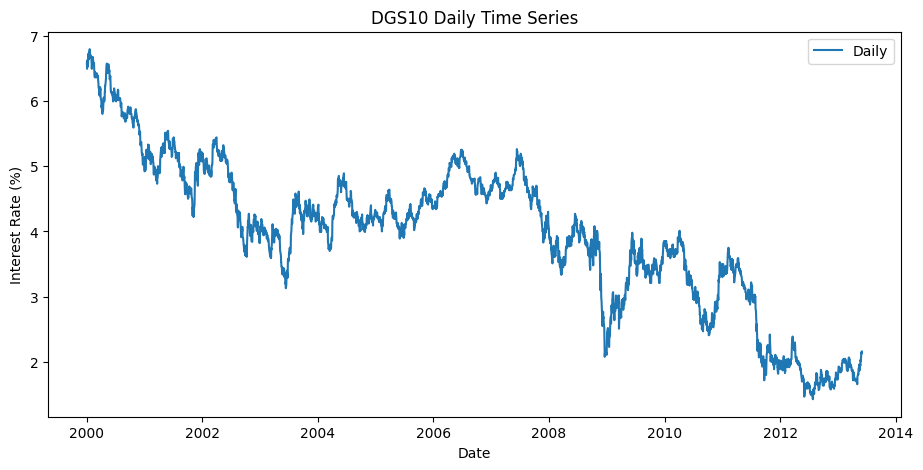

In [6]:
# Create a new Series 'DGS10_daily' with non-missing 'DGS10' data
DGS10_daily = tyields['DGS10'].dropna()

# Print the first few rows and dimensions of the resulting daily data 
print(DGS10_daily.head())
print(DGS10_daily.shape)

# Plot data for the daily time series
plt.figure(figsize=(11, 5))
plt.plot(DGS10_daily, label='Daily')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.title('DGS10 Daily Time Series')
plt.legend()
plt.show()

<h3> Plot DGS10 Weekly Time Series </h3>

In [7]:
# Convert the daily time series to weekly frequency using resample and OHLC data
DGS10_weekly_ohlc = DGS10_daily.resample('W').ohlc()

# Print the first few rows and dimensions of the resulting weekly OHLC data
print(DGS10_weekly_ohlc.head())
print(DGS10_weekly_ohlc.shape)

# Plot the OHLC data for the weekly time series
# mpf.plot(DGS10_weekly_ohlc,  figsize=(11,5), show_nontrading=False, datetime_format='%Y', type='candle', style='yahoo', title='DGS10 Weekly Time Series', ylabel='Interest Rate (%)')

            open  high   low  close
Date                               
2000-01-09  6.58  6.62  6.49   6.52
2000-01-16  6.57  6.72  6.57   6.69
2000-01-23  6.75  6.79  6.73   6.79
2000-01-30  6.69  6.70  6.66   6.66
2000-02-06  6.68  6.68  6.49   6.53
(700, 4)


<h3> Plot DGS10 Monthly Time Series </h3>

In [8]:
# Convert the daily time series to monthly frequency using resample and OHLC data
DGS10_monthly_ohlc = DGS10_daily.resample('M').ohlc()

# Print the first few rows and dimensions of the resulting monthly OHLC data
print(DGS10_monthly_ohlc.head())
print(DGS10_monthly_ohlc.shape)

# Plot the OHLC data for the monthly time series
# mpf.plot(DGS10_monthly_ohlc,  figsize=(11,5), show_nontrading=False, datetime_format='%Y', type='candle', style='yahoo', title='DGS10 Monthly Time Series', ylabel='Interest Rate (%)')

            open  high   low  close
Date                               
2000-01-31  6.58  6.79  6.49   6.68
2000-02-29  6.62  6.67  6.36   6.42
2000-03-31  6.39  6.42  6.03   6.03
2000-04-30  6.00  6.23  5.80   6.23
2000-05-31  6.29  6.57  6.29   6.29
(161, 4)


<h3> DGS10 Daily, Weekly & Monthly Close Time Series </h3>

In [9]:
# Convert the daily time series to weekly frequency and extract the "Close" values
DGS10_weekly = DGS10_daily.resample('W').last()

# Convert the daily time series to monthly frequency and extract the "Close" values
DGS10_monthly = DGS10_daily.resample('M').last()

print(DGS10_daily.shape)
print(DGS10_weekly.shape)
print(DGS10_monthly.shape)

(3356,)
(700,)
(161,)


<h3> DGS10 Daily, Weekly & Monthly Close First Differenced Time Series </h3>

In [10]:
daily_diff = DGS10_daily.diff().dropna()
weekly_diff = DGS10_weekly.diff().dropna()
monthly_diff = DGS10_monthly.diff().dropna()

<h3> Augmented Dickey-Fuller Test For Stationarity / Non-Stationarity </h3>

In [11]:
# Function to perform Augmented Dickey-Fuller Test and print the results
def perform_adf_test(series, period):
    result = sm.tsa.adfuller(series, autolag='AIC')
    print(f"Results for {period} data:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    print("\n")

<h4> ADF Test on Time Series </h4>

In [12]:
# Perform the Augmented Dickey-Fuller Test for un-differenced series
perform_adf_test(DGS10_daily, "daily")
perform_adf_test(DGS10_weekly, "weekly")
perform_adf_test(DGS10_monthly, "monthly")

Results for daily data:
ADF Statistic: -1.9703704586416373
p-value: 0.29971378312193064
Critical Values:
	1%: -3.4323017785053387
	5%: -2.8624023818405093
	10%: -2.5672290628563172


Results for weekly data:
ADF Statistic: -1.9220753092102039
p-value: 0.3217485048691344
Critical Values:
	1%: -3.439739809554328
	5%: -2.86568368980381
	10%: -2.5689766074363334


Results for monthly data:
ADF Statistic: -1.0952829418357857
p-value: 0.7169493427897817
Critical Values:
	1%: -3.473829775724492
	5%: -2.880622899711496
	10%: -2.5769448985432954




For each periodicity, the null hypothesis of a unit root for the time series DGS10 is not rejected at the 0.05 level. The p-value for each test does not fall below standard critical values of 0.05 or 0.01. </br>
The p-value decreases as the periodicity of the data shortens. This suggests that the time-series structure in the series DGS10 may be stronger at higher frequencies.

<h4> ADF Test on First Differenced Time Series </h4>

In [13]:
# Perform the Augmented Dickey-Fuller Test for first-differenced series
perform_adf_test(daily_diff, "daily (1st-differenced)")
perform_adf_test(weekly_diff, "weekly (1st-differenced)")
perform_adf_test(monthly_diff, "monthly (1st-differenced)")

Results for daily (1st-differenced) data:
ADF Statistic: -43.07006048287457
p-value: 0.0
Critical Values:
	1%: -3.4323017785053387
	5%: -2.8624023818405093
	10%: -2.5672290628563172


Results for weekly (1st-differenced) data:
ADF Statistic: -27.08651321968765
p-value: 0.0
Critical Values:
	1%: -3.439753311961436
	5%: -2.8656896390914217
	10%: -2.568979777013325


Results for monthly (1st-differenced) data:
ADF Statistic: -6.914372355281942
p-value: 1.189848810622954e-09
Critical Values:
	1%: -3.473829775724492
	5%: -2.880622899711496
	10%: -2.5769448985432954




For each of the three time periodicities, the ADF test rejects the null hypothesis that a unit root is present for the first-differenced time series.

<h3> Plot ACF & PACF </h3>

<h4> Time Series </h4>

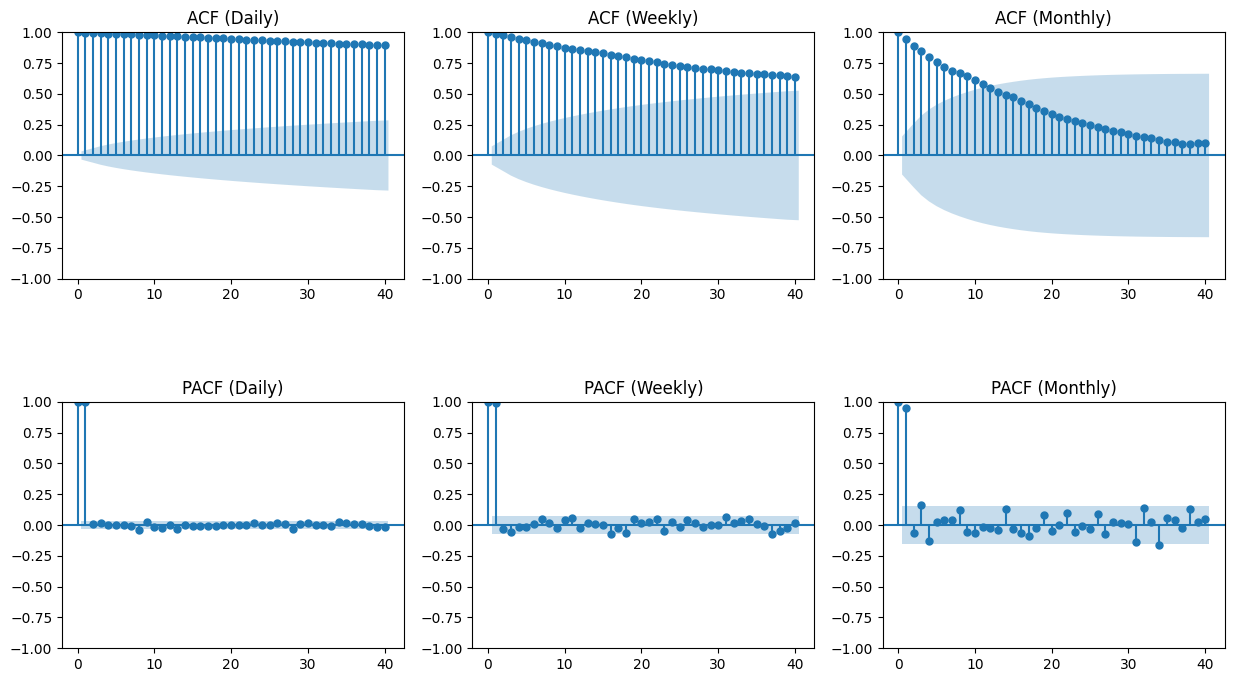

In [14]:
# Plot the ACF and PACF for each periodicity
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

# Plot for daily data
plot_acf(DGS10_daily, ax=axes[0, 0], lags=40, title="ACF (Daily)")
plot_pacf(DGS10_daily, ax=axes[1, 0], lags=40, title="PACF (Daily)")

# Plot for weekly data
plot_acf(DGS10_weekly, ax=axes[0, 1], lags=40, title="ACF (Weekly)")
plot_pacf(DGS10_weekly, ax=axes[1, 1], lags=40, title="PACF (Weekly)")

# Plot for monthly data
plot_acf(DGS10_monthly, ax=axes[0, 2], lags=40, title="ACF (Monthly)")
plot_pacf(DGS10_monthly, ax=axes[1, 2], lags=40, title="PACF (Monthly)")

plt.show()

<h4> First Differenced Time Series </h4>

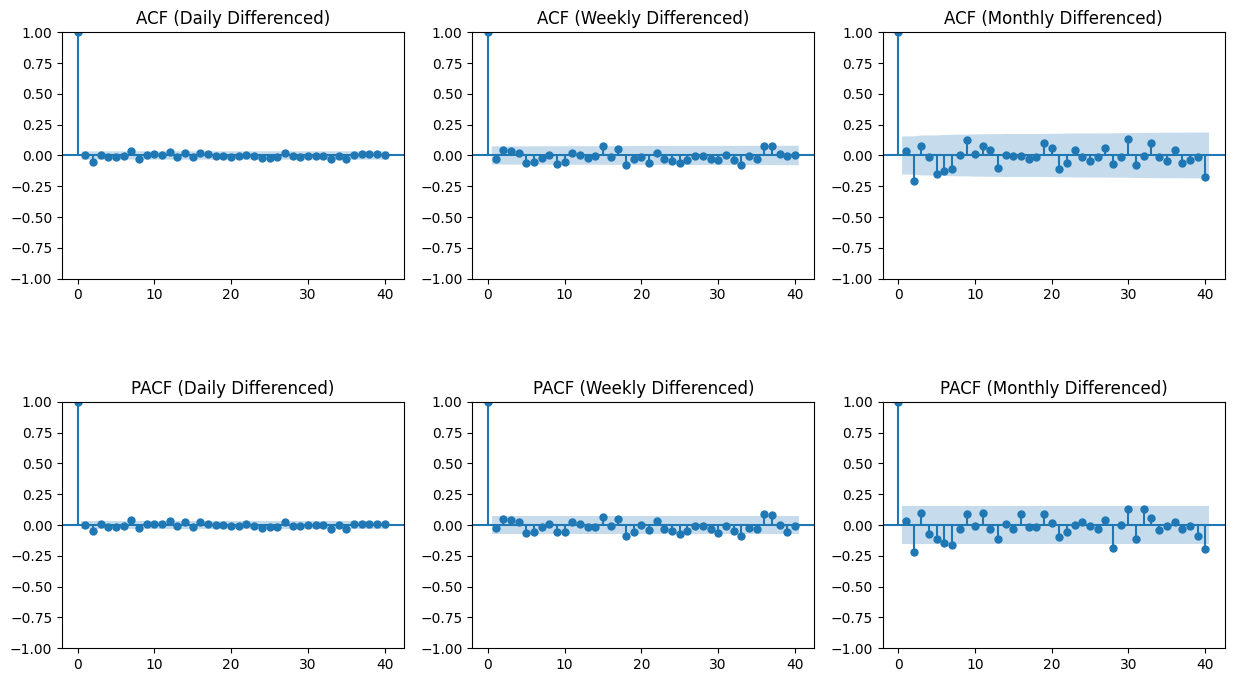

In [15]:
# Plot the ACF and PACF for each periodicity
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

# Plot for daily first differenced time series data
plot_acf(daily_diff, ax=axes[0, 0], lags=40, title="ACF (Daily Differenced)")
plot_pacf(daily_diff, ax=axes[1, 0], lags=40, title="PACF (Daily Differenced)")

# Plot for weekly first differenced time series data
plot_acf(weekly_diff, ax=axes[0, 1], lags=40, title="ACF (Weekly Differenced)")
plot_pacf(weekly_diff, ax=axes[1, 1], lags=40, title="PACF (Weekly Differenced)")

# Plot for monthly first differenced time series data
plot_acf(monthly_diff, ax=axes[0, 2], lags=40, title="ACF (Monthly Differenced)")
plot_pacf(monthly_diff, ax=axes[1, 2], lags=40, title="PACF (Monthly Differenced)")

plt.show()

The apparent time series structure of DGS10 varies with the periodicity: </br>
**Daily:**</br>
strong negative order-2 autocorrelation and partial autocorrelation</br>
strong positive order-7 autocorrelation and partial autocorrelation</br>
**Weekly:**</br>
possible significant correlations at lag 15 (simple) and lag 18 (partial)</br>
**Monthly:**</br>
strong negative order-2 autocorrelation (both simple and partial) </br>

The autocorrelations are modestly larger as the periodicity increases from daily to weekly to monthly.

<h2> DGS10 Monthly Close First Differenced Time Series Analysis </h2>

In [16]:
y0 = DGS10_monthly.diff().dropna()

<h3> Find Best AR(p) Model </h3>

The best AR(p) order is: 7
The AIC value of the best AR model is: 43.74137819778319


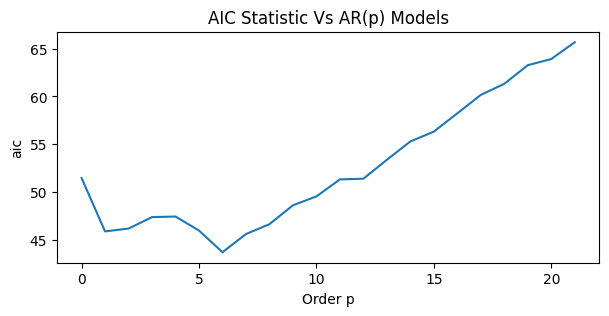

In [17]:
# Fit ARIMA(p,0,0) models with different AR orders (p) and select the best based on AIC
aic = []
best_aic = float("inf")
best_order = None

max_lag = 22

for p in range(1, max_lag+1):
    model = ARIMA(y0, order=(p,0,0))  # AR(p) model with zero differences (d=0) and zero moving average (q=0)
    result = model.fit()
    aic.append(result.aic)
    if result.aic < best_aic:
        best_aic = result.aic
        best_order = p

print(f"The best AR(p) order is: {best_order}")
print(f"The AIC value of the best AR model is: {best_aic}")

# Plot aic vs order p
plt.figure(figsize=(7, 3))
plt.plot(aic)
plt.xlabel('Order p')
plt.ylabel('aic')
plt.title('AIC Statistic Vs AR(p) Models')
plt.show()

<h3> Fit AR(7) Model </h3>

In [18]:
# Create lagged versions of y0
y0_lag1 = y0.shift(1)
y0_lag2 = y0.shift(2)
y0_lag3 = y0.shift(3)
y0_lag4 = y0.shift(4)
y0_lag5 = y0.shift(5)
y0_lag6 = y0.shift(6)
y0_lag7 = y0.shift(7)

# Concatenate the lagged versions into a DataFrame for regression
data = pd.concat([y0, y0_lag1, y0_lag2, y0_lag3, y0_lag4, y0_lag5, y0_lag6, y0_lag7], axis=1)
data.columns = ['y0', 'y0.lag1', 'y0.lag2', 'y0.lag3', 'y0.lag4', 'y0.lag5', 'y0.lag6', 'y0.lag7']

# Drop any rows with missing values after creating the lagged variables
data.dropna(inplace=True)

# Fit the AR(7) model using OLS regression
y = data['y0']
X = data[['y0.lag1', 'y0.lag2', 'y0.lag3', 'y0.lag4', 'y0.lag5', 'y0.lag6', 'y0.lag7']]

X = sm.add_constant(X)  # Add constant term to the model

model = sm.OLS(y,X).fit()

# Print the summary statistics of the fitted model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     y0   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.912
Date:                Tue, 16 Jan 2024   Prob (F-statistic):            0.00703
Time:                        00:19:22   Log-Likelihood:                -12.820
No. Observations:                 153   AIC:                             41.64
Df Residuals:                     145   BIC:                             65.88
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0438      0.023     -1.905      0.0

<h3> AR(7) Model Diagnostics </h3>

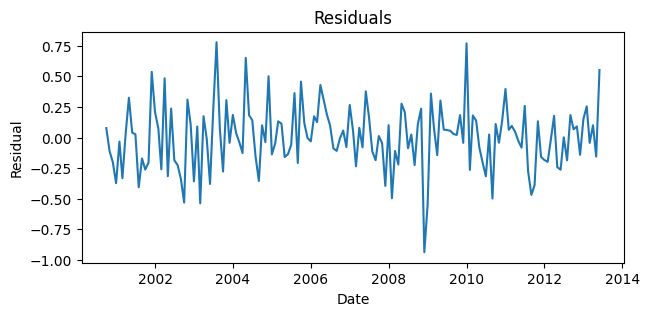

In [19]:
# Get the residuals from the fitted model
residuals = model.resid

# Plot residuals against time
plt.figure(figsize=(7, 3))
plt.plot(residuals.index, residuals.values)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title("Residuals")
plt.show()

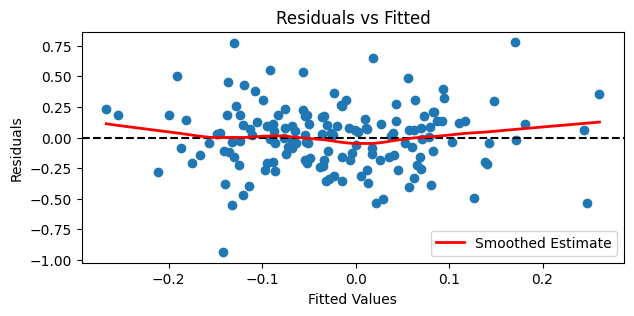

In [20]:
# Create the residuals vs. fitted plot
residuals = model.resid
fitted_values = model.fittedvalues

# Calculate the smoothed estimate using LOESS (locally weighted scatterplot smoothing)
lowess_smoothed = sm.nonparametric.lowess(residuals, fitted_values, frac=0.5)

plt.figure(figsize=(7,3))
plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.legend()
plt.show()

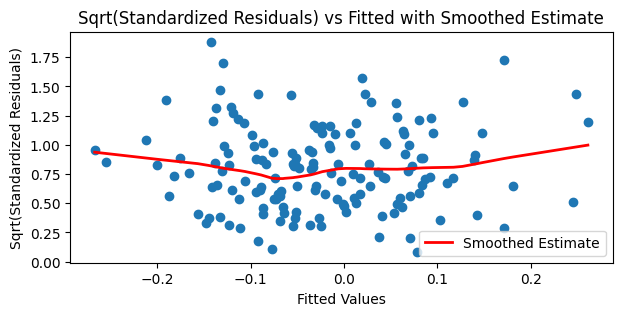

In [21]:
# Calculate the standardized residuals
standardized_residuals = model.get_influence().resid_studentized_internal

# Take the square root of the absolute values of standardized residuals
sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))

# Get the fitted values from the fitted model
fitted_values = model.fittedvalues

# Calculate the smoothed estimate using LOESS (locally weighted scatterplot smoothing)
lowess_smoothed = sm.nonparametric.lowess(sqrt_standardized_residuals, fitted_values, frac=0.5)

plt.figure(figsize=(7,3))
plt.scatter(fitted_values, sqrt_standardized_residuals)
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
plt.xlabel('Fitted Values')
plt.ylabel('Sqrt(Standardized Residuals)')
plt.title('Sqrt(Standardized Residuals) vs Fitted with Smoothed Estimate')
plt.legend()
plt.show()

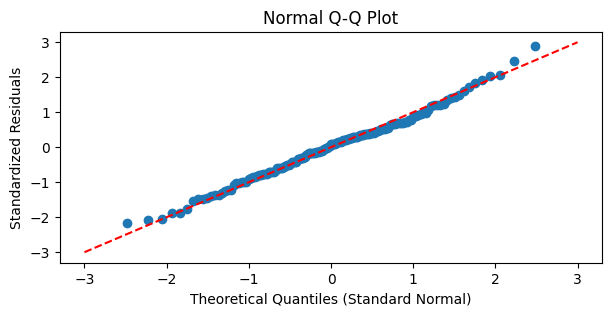

In [22]:
# Calculate the standardized residuals
standardized_residuals = model.get_influence().resid_studentized_internal

# Sort the standardized residuals
sorted_standardized_residuals = sorted(standardized_residuals)

# Calculate theoretical quantiles for the standard normal distribution
theoretical_quantiles = np.linspace(0, 100, len(standardized_residuals))  
theoretical_quantiles_values = stats.norm.ppf(theoretical_quantiles / 100)

# Create the normal Q-Q plot of the standardized residuals
plt.figure(figsize=(7,3))
plt.scatter(theoretical_quantiles_values, sorted_standardized_residuals)
plt.plot([-3, 3], [-3, 3], color='red', linestyle='dashed')
plt.xlabel('Theoretical Quantiles (Standard Normal)')
plt.ylabel('Standardized Residuals')
plt.title('Normal Q-Q Plot')
plt.show()